## Initialization

In [1]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join('..')))
import torch
from kar_hnn import KARHNN
from data import get_dataset

## Help Functions

In [2]:
# print squared loss at specific steps for comparison with HNN
print_every = 200
def print_results(results, print_every=200):
    for step in range(0, len(results["train_loss"]), print_every):
        print(
            "step {}, train_loss {:.4e}, test_loss {:.4e}".format(
                step,
                results["train_loss"][step],
                results["test_loss"][step],
            )
        )
    print('Final train loss {:.4e} +/- {:.4e}\nFinal test loss {:.4e} +/- {:.4e}'
        .format(results["train_loss"][-1], results["train_std"][-1],
                results["test_loss"][-1], results["test_std"][-1]))

def print_best(results):
    curr_min = 0

    for step in range(0, len(results["train_loss"])):
        if results["test_loss"][step] < results["test_loss"][curr_min]:
            curr_min = step
    print(
        "best test loss at step {}, train_loss {:.4e}, test_loss {:.4e}".format(
            curr_min,
            results["train_loss"][curr_min],
            results["test_loss"][curr_min],
        )
    )


## Create Dataset

In [3]:
# create dataset
data = get_dataset(seed=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.tensor(data["x"], requires_grad=True, dtype=torch.float32).to(device)
test_x = torch.tensor(data["test_x"], requires_grad=True, dtype=torch.float32).to(device)
dxdt = torch.Tensor(data["dx"]).to(device)
test_dxdt = torch.Tensor(data["test_dx"]).to(device)

# dataset['train_input'], dataset['train_label'],dataset['test_input'], dataset['test_label']
dataset = {
    "train_input": x,
    "train_label": dxdt,
    "test_input": test_x,
    "test_label": test_dxdt,
}

In [4]:
dataset["train_input"].shape, dataset["train_label"].shape

(torch.Size([750, 2]), torch.Size([750, 2]))

## Model Training

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# initialize KAN with G=3
model = KARHNN(input_dim=2, width=[2, 2, 2], grid=2, k=5, seed=1, device=device)
results = model.fit(dataset, opt="LBFGS", steps=170, log=1,batch=50)
print_results(results, 1)
print_best(results)


cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.52e-02 | test_loss: 2.86e-02 | reg: 5.70e+00 | : 100%|█| 170/170 [00:10<00:00, 15.46

saving model version 0.1
step 0, train_loss 4.4342e-02, test_loss 7.4276e-02
step 1, train_loss 2.2120e-02, test_loss 5.3855e-02
step 2, train_loss 3.1496e-02, test_loss 4.1798e-02
step 3, train_loss 3.2065e-02, test_loss 4.3065e-02
step 4, train_loss 2.7892e-02, test_loss 4.2625e-02
step 5, train_loss 3.1776e-02, test_loss 4.3396e-02
step 6, train_loss 2.5734e-02, test_loss 3.5492e-02
step 7, train_loss 2.3912e-02, test_loss 4.0744e-02
step 8, train_loss 3.1598e-02, test_loss 3.8487e-02
step 9, train_loss 3.8729e-02, test_loss 4.1972e-02
step 10, train_loss 3.2624e-02, test_loss 4.2785e-02
step 11, train_loss 3.2715e-02, test_loss 4.1267e-02
step 12, train_loss 2.8916e-02, test_loss 4.7376e-02
step 13, train_loss 2.4936e-02, test_loss 5.3146e-02
step 14, train_loss 3.5932e-02, test_loss 5.1131e-02
step 15, train_loss 3.8108e-02, test_loss 3.3600e-02
step 16, train_loss 2.5291e-02, test_loss 7.6313e-02
step 17, train_loss 3.2043e-02, test_loss 3.3928e-02
step 18, train_loss 3.7193e-02,

[tensor([nan, nan], grad_fn=<MeanBackward1>), tensor([nan, nan], grad_fn=<MeanBackward1>), tensor([0.5000, 0.5000], grad_fn=<MeanBackward1>)]


UnboundLocalError: cannot access local variable 'alpha_mask' where it is not associated with a value

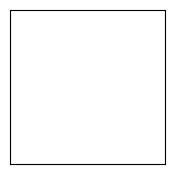

In [6]:
model.attribute()
print(model.node_scores)
model.plot()

saving model version 0.2


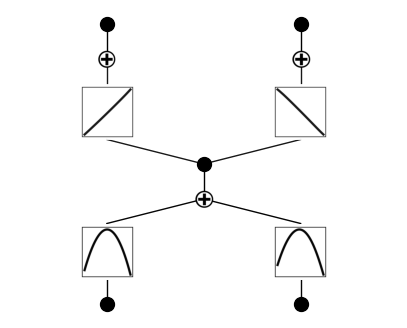

In [22]:
model = model.prune_node(threshold=1e-1)
model.plot()

In [23]:
mode = "manual"  # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0, 0, 0, "x^2")
    model.fix_symbolic(0, 1, 0, "x^2")
    model.fix_symbolic(1, 0, 0, "x")
    model.fix_symbolic(1, 0, 1, "x")
elif mode == "auto":
    # automatic mode
    lib = ["x", "x^2", "x^3", "x^4", "sqrt", "tanh", "sin", "abs"]
    model.auto_symbolic(lib=lib)

r2 is 0.9998692274093628
saving model version 0.3
r2 is 0.9997871518135071
saving model version 0.4
Best value at boundary.
r2 is 0.9996123313903809
saving model version 0.5
r2 is 0.9998849630355835
saving model version 0.6


In [24]:
from kan.utils import ex_round

[ex_round(y, 4) for y in model.symbolic_formula()[0]]

[-0.0255*(x_1 + 0.0005)**2 - 0.0258*(x_2 - 0.0056)**2 - 0.0127,
 0.9815*(x_1 + 0.0005)**2 + 0.9925*(x_2 - 0.0056)**2 - 0.8103]

![hnn](./hnn.png)
![baseline](./baseline.png)
